<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/EIP4/session4/002_EIP4_CIFAR10_ResNet_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize where the Convolutional Network is looking at using Grad-CAM for CIFAR10 dataset 

When solving image classification problems , it would be helpful for us to know what information from the image is being used by the network to make its preditions. Grad-CAM is a way for us to visualize the pixels in the activation channels that contribute most actively to a certain prediction . This will help us to fine tune the model in such a way that it uses all/most of the information belonging to the object being classified while making a prediction as opposed to using only small parts of the object or on the fringes or background surrounding the object being classified. This will help the model learn more about the features of a particular class .

In this exercise we will do a Grad-CAM visualization on 10 misclassified images of CIFAR10 dataset. We will use a ResNet18 model based on the notes for CIFAR-10 in the [RESNET paper](https://arxiv.org/pdf/1512.03385.pdf) 

![resnet-notes1](https://raw.githubusercontent.com/srbharathee/DL/master/images/resnet-notes1.png)
![resnet-notes2](https://raw.githubusercontent.com/srbharathee/DL/master/images/resnet-notes2.png)

Based on these experiments of the authors on CIFAR-10 a Resnet20 Model has been defined in [https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py](https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py) . We will use ResNetv2 from this project  for CIFAR-10 dataset . 

We will make a few small changes:
1. Remove the last Dense layer 
2. Add a Conv2D 1x1 to reduce the number of channels to 10 (reducer1)

The modified file is at [https://raw.githubusercontent.com/srbharathee/DL/master/cifar10_resnet20.py](https://raw.githubusercontent.com/srbharathee/DL/master/cifar10_resnet20.py)


We will add the following image augmentations
1. Cutout -  cutout 8x8 sections of the image and replace it with the train data mean value 
2.  random horizontal flip , 
3. Random pad crop  - Here we will pad the image by 4 on all sides to get a 40x40 image and then randomly crop 32x32 sections from this padded image 
 
 We will implement our own cutout and random pad crop functions by treating the images as numpy arrays

After training the model for 50 epochs , we will do a prediction on the test dataset and  get the 10 misclassified images .

We will apply Grad-CAM visualization on these 10 misclassified images 


### get the Modified ResNet file which is based on an implementation from keras-team project 

In [0]:
!wget https://raw.githubusercontent.com/srbharathee/DL/master/cifar10_resnet20.py

--2019-12-05 04:43:30--  https://raw.githubusercontent.com/srbharathee/DL/master/cifar10_resnet20.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11268 (11K) [text/plain]
Saving to: ‘cifar10_resnet20.py.2’

cifar10_resnet20.py 100%[===================>]  11.00K  --.-KB/s    in 0s      

2019-12-05 04:43:31 (98.2 MB/s) - ‘cifar10_resnet20.py.2’ saved [11268/11268]



### import necessary keras modules , numpy and matplotlib

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
#from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


### import the modified ResNet20 that we have downloaded  

In [0]:
import cifar10_resnet20

In [0]:
model=cifar10_resnet20.resnet_v2(input_shape=(32,32,3),depth=cifar10_resnet20.depth)

In [0]:
cifar10_resnet20.depth

20

### print model summary and use this information to choose the layer that we will vuse for Grad-CAM visualization. 

### We will use 'reducer1' with size of 8x8 

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Plot the model as png image so that we can visualize the network better 

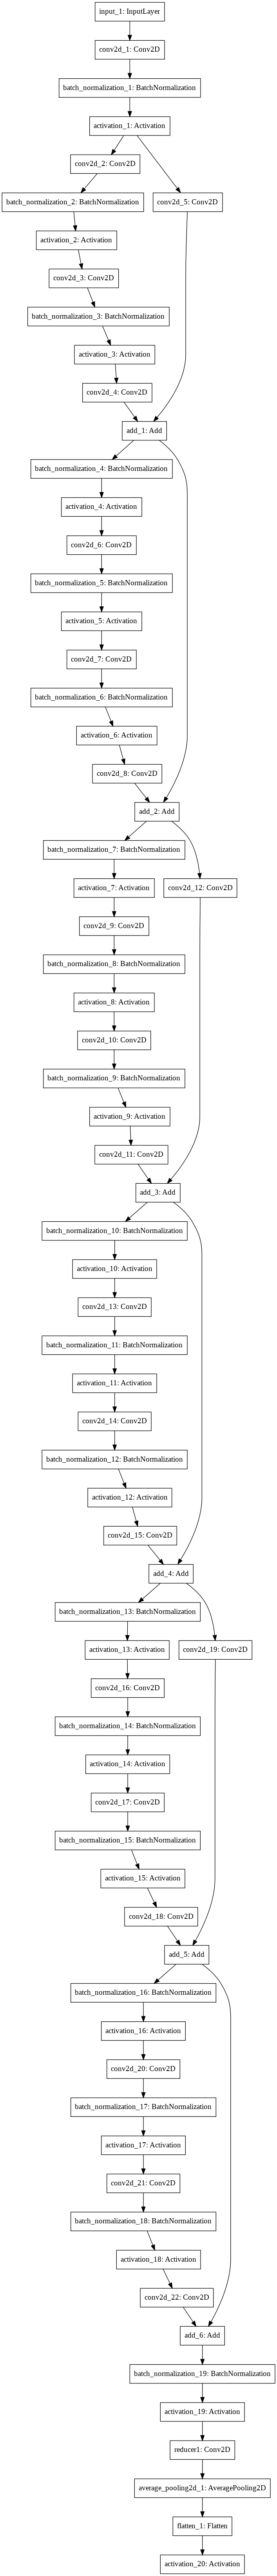

In [0]:
#plot the model as a png image and display it 

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image, display
display(Image('model.png'))

### We will choose the layer 'reducer1' (which is nearest to prediction and has a size of 8x8 ) to be used for Grad-CAM Visualization

### get cifar10 dataset from keras datasets 

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

### plot a selection of 10 images from the train dataset 

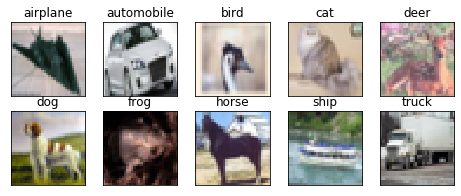

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Normalize pixel values in the images to be between 0 and 1
### convert the train and test labels to categorical data of 10 class categories 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

train_mean = np.mean(train_features, axis=(0,1,2))
train_std = np.std(train_features, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') 

def pad4(img):
  pad_size=img.shape[1]//8
  img=np.pad(img, [ (pad_size, pad_size), (pad_size, pad_size), (0, 0)], mode='reflect')  
  return img 

train_features = normalize(train_features)
test_features = normalize(test_features)

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)



### Compile the model using Stochastic Gradient descent optimizer with momentum of 0.9 

In [0]:
# train
from keras.optimizers import SGD
opt=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


### we want to get the model with best validation accuracy for the prediction task and so we will save the best model from the various epochs in Google Drive using ModelCheckpoint callback available in Keras 
### Mount Google Drive  

In [0]:
from google.colab import drive 
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


### define a Modelcheckpoint to save the best Model 

In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path='/gdrive/My Drive/EIP4/session4/best_model.h5'

chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

##Cutout Augmentation
Cutout was first presented as an effective augmentation technique in these two papers :

[Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/abs/1708.04552) and [Random Erasing Data Augmentation](https://arxiv.org/abs/1708.04896)

The idea is to randomly cut away patches of information from images that a model is training on to force it to learn from more parts of the image. This would help the model learn more features about a class instead of depending on some simple assumptions using smaller areas within the image . This helps the model generalize better and make better predictions .

Below is a cutout function that randomly cuts out portion of an image and assigns the mean value of the train set to the cut portion 

In [0]:
def cutout(img):
  s1=img.shape[0]
  
  x1=np.random.randint(s1)
  
  
  x2=x1+s1//4 
  if x2>s1:
    x2=s1
  img[x1:x2,x1:x2,:]=train_mean
  

  return img


### Random-pad-crop 
We will also pad the images to 40 pixels and randomly crop out 32x32 sections from this padded image .Below is the function which does the random-pad-crop augmentation. Random-pad-crop is also a standard augmentation technique used in image classification 

In [0]:
def random_pad_crop_img(img,crop_size=32):
  crop_size=img.shape[1]
  img=pad4(img)
  pad=img.shape[1]-crop_size
  x1=np.random.randint(pad)
  x2=x1+crop_size
  y1=np.random.randint(pad)
  y2=y1+crop_size
  img=img[x1:x2,y1:y2,:]
  return img

### Train the model for 50 epochs using a batch size of 128  . We will use a ImageDataGenerator to apply image augmentation of random horizontal Flip, random-pad-crop  and CutOut augmentation for the training in addition to image normalization on the train and test datsets 

In [0]:
def img_aug1(img):
  img=random_pad_crop_img(img)
  img=cutout(img)
  return img

### one-cycle-LR-policy
One-cycle-LR policy was made famous by Leslie Smith in his experiments for superconvergence. Here we increase the LR to a high value during the initial few epochs and then decrease it every epoch . This helps in the model converging faster . we will use an LR schedule that increases from 0.01 to 0.2 (in the 6th epoch) and then decreases towards 0 as training progresses 

In [0]:
from keras.callbacks import LearningRateScheduler

def scheduler(epoch):
  lr=np.interp([epoch],[0, EPOCHS//8,EPOCHS], [0.01, 0.2, 0])[0]
  print('epoch ', epoch+1, ': setting learning rate to ',lr)
  return lr
  

lr_sched = LearningRateScheduler(scheduler)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
#from random_eraser import get_random_eraser
EPOCHS=50
batch_size=128

train_datagen=ImageDataGenerator(
        #featurewise_center=True,  # set input mean to 0 over the dataset
        #samplewise_center=False,  # set each sample mean to 0
        #featurewise_std_normalization=True,  # divide inputs by std of the dataset
        #samplewise_std_normalization=False,  # divide each input by its std
        preprocessing_function=img_aug1,
        horizontal_flip=True
    
)

val_datagen= ImageDataGenerator(
        #featurewise_center=True,  # set input mean to 0 over the dataset
        
        #featurewise_std_normalization=True,  # divide inputs by std of the dataset
        
)


train_datagen.fit(train_features)

val_datagen.fit(test_features)

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(training_generator, epochs=EPOCHS, 
                        steps_per_epoch=np.ceil(train_features.shape[0]/batch_size), 
                    validation_steps=np.ceil(test_features.shape[0]/batch_size), 
                    validation_data=validation_generator,
                                 shuffle=True,
                                 callbacks=[chkpoint_model,lr_sched],
                                 verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
epoch  1 : setting learning rate to  0.01
391/391 [==============================] - 39s 101ms/step - loss: 2.2419 - acc: 0.3350 - val_loss: 2.0195 - val_acc: 0.4124

Epoch 00001: val_acc improved from -inf to 0.41240, saving model to /gdrive/My Drive/EIP4/session4/best_model.h5
Epoch 2/50
epoch  2 : setting learning rate to  0.04166666666666667
391/391 [==============================] - 34s 87ms/step - loss: 1.9183 - acc: 0.4521 - val_loss: 2.1830 - val_acc: 0.3985

Epoch 00002: val_acc did not improve from 0.41240
Epoch 3/50
epoch  3 : setting learning rate to  0.07333333333333333
391/391 [==============================] - 34s 87ms/step - loss: 1.6503 - acc: 0.5499 - val_loss: 1.6953 - val_acc: 0.5468

Epoch 00003: val_acc improved from 0.41240 to 0.54680, saving model to /gdrive/My Drive/EIP4/session4/best_model.h5
Epoch 4/50
epoch  4 : setting learning rate to  0.105
391/391 [

### The network was trained for 50 epochs and reached a max validation accuracy of 91.76 . 
### There is still scope for this model to learn if trained for more epochs as the training accuracy is only at 95.14 but we will stop here and focus on GradCAM visualization .
### We have saved the model with best validation accuracy in google drive so that we can load and use it for prediction and Grad-CAM visualization 

#GRAD-CAM

### Now let us define the function for Grad-CAM visualization . 
### This function named gradcam takes as input the model , the set of images , the labels for each image and the layer to be used for calculating gradients . 
### It returns a list of dictionaries containing original image , the heatmap, the titles to display during visualization 

In [0]:
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from google.colab.patches import cv2_imshow
from IPython.core.display import display, HTML


#select test images and corresponding labels to print heatmap 
#x=np.array([test_features[41],test_features[410],test_features[222],test_features[950]])
#y=[test_labels[41],test_labels[410],test_labels[222],test_labels[950]]


def gradcam(model1,x,y,which_layer):
  #
  results=[]
  #make prediction for these 4 images 
  preds = model1.predict(x)
  for j in range(x.shape[0]):
    #get class id from the prediction values 
    class_idx = np.argmax(preds[j])

    class_output = model1.output[:, class_idx]
  
    ## choose the layer nearest to prediction that has a size of about 7x7 or 8x8 
    #in this case it is the layer being sent to the gradcam function 
    last_conv_layer = model1.get_layer(which_layer)
  
    # compute gradients and from heatmap 
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    #apply the pooled grad value to the conv layer channels 
    for i in range(10):
      
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
      
    #get the mean of the weighted values and assign to heatmap   
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    #retain only positive values (or 0) in heatmap 
    heatmap = np.maximum(heatmap, 0)
    #convert values between 0 and 1 using divide by max value 
    heatmap /= np.max(heatmap) 
    #we now have a heatmap with size equal to the output size of the layer we chose 
    
    #img is the image we are running gradcam on 
    img = x[j]
    
    #resize heatmap 8x8 to image size of 32x32 
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    #convert pixel values to be between 0 and 255 
    heatmap = np.uint8(255 * heatmap)
    #apply suitable cv2 colormap . In this case colormap_JET 
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
    # convert from BGR to RGB if we want to display using matplotlib 
    heatmap1 = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # create superimposed image if we want to print using cv2 (cv2_imshow supported in colab)
    superimposed_img = cv2.addWeighted(img, 0.5, heatmap1, 0.5, 0,dtype=5)
    
    #create a dictionary object with details of image, heatmap, its title 
    title1=str(j+1)+": "+ class_names[np.argmax(y[j])]+"\npredicted as\n"+str(class_names[class_idx])
    title2='superimposed\nheatmap'
    image1=img
    image2=heatmap1
    image3=superimposed_img
    imageObj={'image1':image1,'image2':image2,'image3':image3,'title1':title1,'title2':title2}
    
    #append the image dict object to results list 
    results.append(imageObj)
    #print(j)
  #return grad-cam results as a list of dictionary objects , each containing an image and its heatmap  
  return results  



### Define the functions required to display the Grad-CAM visualizations . 


Function to denormalize the normalized images from the test set. This is done to properly display the images using matplotlib

In [0]:
denormalize = lambda x: (x.copy()*train_std +train_mean).astype('float32')

### This function displays a set of two images with heatmap visuals per row 

In [0]:
def displayRow(images):
  # we will plot 2 images in a row 
  # cv.imshow does not work in jupyter notebooks and colab 
  # cv2_imshow patch works on colab but matplotlib gives us a little more flexibility in formatting the display
  # we will use matplotlib to print the image and its heatmap 
  fig = plt.figure(1, (13,13))

  grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1,5),  
                 axes_pad=1,label_mode="1"  
                 )
  
  #horizontal spacer
  
    
  #grid[0].imshow(np.ones((32, 10)),alpha=0)
  #grid[0].axis('off')
  
  images[0]['image1']=denormalize(images[0]['image1'])
  images[1]['image1']=denormalize(images[1]['image1'])
  
  
  
  
  
  #first image
  #print(" original class is :"+class_names[np.argmax(y[j])]+" and predicted class is :"+str(class_names[class_idx]))
  grid[0].imshow(images[0]['image1'])
  grid[0].set_title(images[0]['title1'])
  grid[0].axis('off')
  
  #print the original image and on top of it place the heat map at 60% transparency 
  grid[1].imshow(images[0]['image1'],alpha=0.9)
  grid[1].imshow(images[0]['image2'],alpha=0.6)
  grid[1].set_title(images[0]['title2'])
  grid[1].axis('off')
  
  #vertical separator 
    
  grid[2].imshow(np.ones((32, 1)))
  grid[2].axis('off')
  
  #second image 
    
  #print(" original class is :"+class_names[np.argmax(y[j])]+" and predicted class is :"+str(class_names[class_idx]))
  grid[3].imshow(images[1]['image1'])
  grid[3].set_title(images[1]['title1'])
  grid[3].axis('off')
  
  #print the original image and on top of it place the heat map at 60% transparency 
  grid[4].imshow(images[1]['image1'],alpha=0.9)
  grid[4].imshow((images[1]['image2']).astype('uint8'),alpha=0.6)
  grid[4].set_title(images[1]['title2'])
  grid[4].axis('off')
  
  
  
  plt.show()
  display(HTML("<hr size='5' color='black' width='100%' align='center' />"))

### Now that we have done the preparatory work for the visualization , let us load the model with best validation accuracy from earlier training 

In [0]:
from keras.models import load_model
model=load_model(model_save_path)

#### test the accuracy score 

In [0]:
score=model.evaluate_generator(validation_generator)
print('validation accuracy =',score[1])

validation accuracy = 0.9176


### Make predictions using the model and collect all the images that were classified wrongly 

In [0]:
pred=model.predict(test_features)
pred2=np.argmax(pred,axis=1)
wrong_set=[]
correct_set=[]
wrong_labels=[]
true_labels=[]
wrong_indices=[]
for i in range(test_features.shape[0]):
  
  if (pred2[i]==np.argmax(test_labels[i])):
    
    correct_set.append(test_features[i])
  else:
    wrong_indices.append(i)
    wrong_labels.append(class_names[pred2[i]])
    true_labels.append(class_names[np.argmax(test_labels[i])])
    wrong_set.append(test_features1[i])


### Now take the first 10 mis-classified images and the corresponding labels to create the data for Grad-CAM visualization 

In [0]:
#take the first 10 images and labels from misclassified set 
w_list=wrong_indices[:10]
x=[]
y=[]
for i in range(len(w_list)):
  x.append(test_features[w_list[i]])
  y.append(test_labels[w_list[i]])
  
#convert the image list to numpy array   
x=np.array(x)

### Obtain results from the gradcam function 

In [0]:
results=gradcam(model,x,y,'reducer1') # we choose this layer as the layer nearest to prediction and having a size of 8x8 


### display the results from gradcam function with images and corresponding heatmap visuals

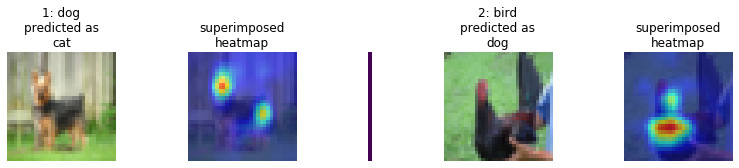

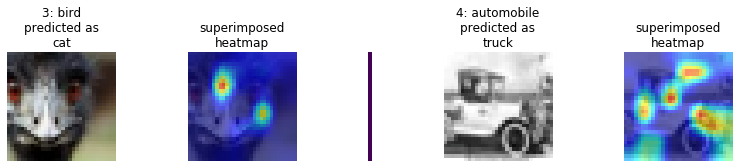

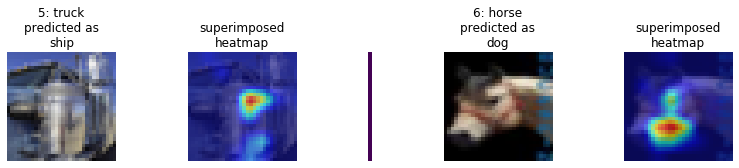

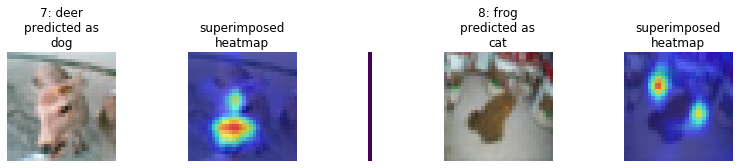

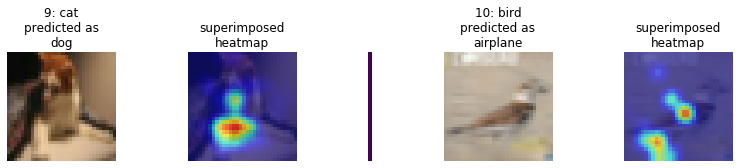

In [0]:
display(HTML("<h2 align='center'>Grad-CAM heatmap for 10 mis-classified images</h2><hr size='5' color='black' width='100%' align='center' />"))
for i in range(0,len(results),2):
  images=[]
  images.append(results[i])
  images.append(results[i+1])
  displayRow(images)

We used a ResNet20 model as per the experiments done by the original authors of ResNet for CIFAR10 dataset . 

The model reached a validation accuracy of 91.76 within 50 epochs.

We made predictions on the dataset and collected 10 misclassified images. We then used Grad-CAM to visualize the heatmap for each of these 10 images and displayed the images together with the heatmaps for a better undertsanding of where the model is looking at or which pixels in a chosen layer are most actively contributing when making predictions for a certain class 